This page lists projects which might be suitable for undergraduate research.

<!-- TEASER_END -->

# Table of Contents
 <p><div class="lev1 toc-item"><a href="#From-Symbols-to-Numbers" data-toc-modified-id="From-Symbols-to-Numbers-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>From Symbols to Numbers</a></div><div class="lev2 toc-item"><a href="#Use-Cases" data-toc-modified-id="Use-Cases-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Use Cases</a></div><div class="lev3 toc-item"><a href="#Lagrangian-Dynamics" data-toc-modified-id="Lagrangian-Dynamics-111"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Lagrangian Dynamics</a></div><div class="lev3 toc-item"><a href="#Neutron-Stars" data-toc-modified-id="Neutron-Stars-112"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Neutron Stars</a></div><div class="lev2 toc-item"><a href="#Existing-Tools" data-toc-modified-id="Existing-Tools-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Existing Tools</a></div><div class="lev1 toc-item"><a href="#Numerical-Differentiation" data-toc-modified-id="Numerical-Differentiation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Numerical Differentiation</a></div><div class="lev2 toc-item"><a href="#Richardson-Extrapolation" data-toc-modified-id="Richardson-Extrapolation-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Richardson Extrapolation</a></div>

# From Symbols to Numbers

Often we have a set of equations that need to be implemented numerically.  To quickly get code working, while ensuring that no mistakes are made, it is often convenient to start with the symbolic expressions and then generate code that performs the numerical computation.  This is especially useful when working with minimizers or solvers that can utilize derivative information.

However, when nested deeply, or highly differentiated, even relatively simple expression can become unweildy in their final form.  The goal of this project is to provide an efficient and effective set of tools for getting from symbolic expressions to the robust code required to evaluate them numerically.

## Use Cases

### Lagrangian Dynamics

Consider the problem of setting up the Euler-Lagrange equations for a triple pendulum.  This generates pretty nasty expressions.

### Neutron Stars

As a use case, we have a project for modelling the physics of neutron stars.  Here the star is described by a nuclear equation-of-state (EoS) defined by the function $\mathcal{E}(n_n, n_p)$ which is the energy-density (energy per unit volume) of homogeneous nuclear matter as a function of neutron $n_n$ and proton $n_p$ densities.  This expression on its own is rather large as it results from inverting a system of 5 linear equations, but then must be inserted into a further set of equations defining the so-called compressible liquid drop model (CLDM) for nuclei which approximates the construction of a nuclear lattice in the crust of the neutron star by minimizing the total energy including electromagnetic interaction and surface effects.  Inserting $\mathcal{E}(n_n, n_p)$ into these equations and taking derivatives as required to define the minimization conditions produces huge expressions that take hours to even simplify.

We practically solved this problem by treating $\mathcal{E}(n_n, n_p)$ as a numerical black box, and decoupling the form of these expressions from the CLDM model.  This is not ideal, however, as it required defining an appropriate interface for calling $\mathcal{E}(n_n, n_p)$ which was additional programming work.

## Existing Tools

Most of our code is in python, so we would like to start there.  I am aware of the following tools which might be useful:

* [SymPy](http://www.sympy.org/): This is the "standard" symbolic manipulation package for python.  It has quite a few tools, and works reasonably well.  Here are some notes, including serious limitations:
  * **Simplification:** Once large expressions are generated, the simplification tools are very slow.  In particular, the default approach `expr.simplify()` tries many different strategies, then measures the outcomes.  Some of these strategies are extremely expensive, so this can literally take hours.  Unfortunately, no record is kept about which strategies worked and which did not, so one cannot easily issolate the best approach.  One small community project might be to look at the `sympy` code and at least keep track of which simplification strategy worked the best so the user can call that directly in the future.
  * **Numerical Computation:** Once an expression is found, fairly efficient numerical implementations can be produced using [``sympy.lambdify``](http://docs.sympy.org/latest/modules/utilities/lambdify.html).  Performance characteristics of various numerical approaches are [discussed here](http://docs.sympy.org/latest/modules/numeric-computation.html).
  * **Caching:**  Once work is done simplifying and generating numerical functions, it would be great to cache these to disk so they can be reused without future expensive computations.  Unfortunately, general expressions and lambdified expressions in particular have no good way to be archived.  Expressions can often be converted to strings, but these take some time to process when loading, which can be a performance issue.  Caching the lamdified functions is thus preferred from a performance standpoint, but runs into many issues:
    * [How to serialize sympy lambdified function?](http://stackoverflow.com/questions/31314517/how-to-serialize-sympy-lambdified-function)
    * [Cannot pickle lambdas from SymPy](https://github.com/uqfoundation/dill/issues/104)
    * [Python - write symbolic expression (sympy) to txt file](http://stackoverflow.com/questions/17517651/python-write-symbolic-expression-sympy-to-txt-file)
    * [Cannot pickle sympy.UndefinedFunction](https://github.com/cloudpipe/cloudpickle/issues/65)
  
    Many of these issues have been partially resolved using appropriate settings of advanced pickling libraries such as [dill](https://pypi.python.org/pypi/dill) or [cloudpickle](https://github.com/cloudpipe/cloudpickle), but they demonstrate that this approach can be brittle.  Another issue is that pickles can "go sour" meaning that if you upgrade your code, or even the underlying python interpreter, the pickles might not be able to be loaded.
  
    My preferred approach is to use human-readable (and writable) representations and have had reasonable success using [`sympy.printing.lambdarepr.NumPyPrinter`](http://docs.sympy.org/latest/modules/printing.html?highlight=lambdarepr#module-sympy.printing.lambdarepr) to print an importable module with the following structure:

    ```python
from __future__ import division
import math
import numpy
import uncertainties.core
import uncertainties.unumpy
import sympy
                                         # Comment to keep nice formatting in 
                                         # notebook... (not sure why needed)
class Mixin(object):
    _names = {names}

    @staticmethod
    def {name}(*v):
        MutableDenseMatrix = numpy.array

        if any([isinstance(_v, sympy.Expr) for _v in v]):
            np = sympy
            MutableDenseMatrix = sympy.MutableDenseMatrix
        elif any([isinstance(_v, uncertainties.core.AffineScalarFunc) for _v in v]):
            np = uncertainties.unumpy
        elif any([isinstance(_v, numpy.ndarray) for _v in v]):
            np = numpy
        else:
            np = math

        exp, log, pi = np.exp, np.log, numpy.pi
        {args} = v
        return {expr}
```
  
    This provides a human friendly form of importable code with minimal performance hits.  It also allows the functions to be called symbolically, with numpy, or with numbers.  However, it is a bit of a hack and requires careful attention to where these "cache" files are stored.
    
* [Theano](http://deeplearning.net/software/theano/): This project is designed to produce optimized code for symbolic expressions using the CPU, multiple threads, and GPU accelleration if possible.  It works, supports CSE, and is quite fast, but unfortunately, the expression manipulation is all done internally and the results are not easily extracted.  It is also a somewhat large package and can be difficult to install (as opposed to sympy which is pure python).  I also find Theano to be less intuitive to use than SymPy.

  In 2013 people looked at translation between SymPy and Theano.  Here are some discussions about using both SymPy and Theano.  This does not seem to be currently an active topic:
  
  * [Theano + Sympy for system of ODEs](https://groups.google.com/forum/#!topic/sympy/VtaxCRNO4sE/discussion)
  * [theano_sympy](https://github.com/nouiz/theano_sympy) github project.
  * [Matthew Rocklin's blog]](http://matthewrocklin.com/blog/) about [Sympy and Theano](http://matthewrocklin.com/blog/tags.html#SymPy-ref) (2013)
    * [Code Generation](http://matthewrocklin.com/blog/work/2013/03/19/SymPy-Theano-part-1)
    * [Scalar Simplification](http://matthewrocklin.com/blog/work/2013/03/28/SymPy-Theano-part-2)
    * [Matrix Expressions](http://matthewrocklin.com/blog/work/2013/04/05/SymPy-Theano-part-3)
    * [Using SymPy within Theano](http://matthewrocklin.com/blog/work/2013/08/14/SymPy-Theano-part-4)
    
The crux of this project thus seems to be about combining an efficient symbolic computation path for specifying non-linear equations with a CSE aware simplification process for computing derivatives etc. and finally generating somewhat optimized numerical code.  (Using [Numba](http://numba.pydata.org) would be great too.)

# Numerical Differentiation

In many applications, one needs to compute derivatives numerically.  In principle this is a straightforward application of the formula:

$$
  f'(x) = \frac{f(x + h) - f(x - h)}{2h} + h^2\frac{f'''(x)}{6} + \order(h^4).
$$

However, in practice, one must trade truncation errors (minimized by making $h$ as small as possible) with roundoff errors amplified in the subtraction.  To be explicit, assume that $f(x)$ can be computed to a relative precision of $\epsilon$.  The roundoff error in this expression is thus of the order:

$$
  \text{roundoff error (relative)} \sim \frac{\epsilon}{\sqrt{2}h}.
$$

Balancing these we obtain an optional value of:

$$
  h_c \approx \sqrt[3]{\frac{6\epsilon f(x)}{\sqrt{2}f'''(x)}} \approx 1.6x\sqrt[3]{\epsilon}
$$

assuming that $f'''(x)/f(x) \sim x^{-3}$.  Even with this optimal step size, the relative error will be of order $\epsilon^{2/3}/2x$ which for double precision reduces the precision from 16 digits to 10.  Here we demonstrate these fomulae these for the function $\sin'(x) = \cos(x)$ at $x=1$:

Populating the interactive namespace from numpy and matplotlib
Max rel. err. in denom: 0.00256821005781


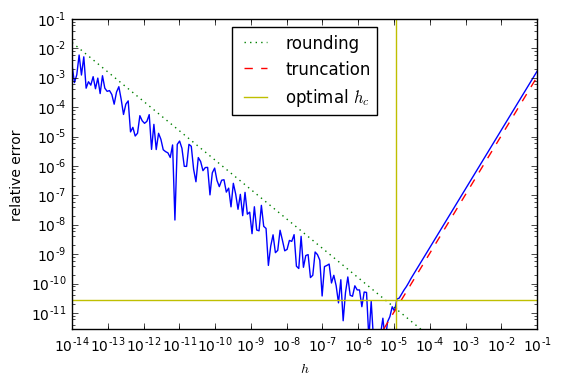

In [1]:
%pylab inline --no-import-all

x = 1.0
f = np.sin
df = np.cos
dddf = lambda x: -np.cos(x)

eps = np.finfo(float).eps

hs = 10**np.linspace(-14, -1, 200)

# This is a numerical trick which helps a bit: There is some roundoff
# error in the computation of x+h and x-h.  Here we set the denominator to
# be exactly the difference between these points, which might differ slightly
# from 2*hs
denom = (x+hs) - (x-hs)
print("Max rel. err. in denom: {}".format(abs((2*hs - denom)/denom).max()))

df_numeric = (f(x+hs) - f(x-hs))/denom

err = abs((df_numeric - df(x))/df(x))

h_c = 1.6 * (eps / abs(dddf(x)/f(x)))**(1./3.)
err_c = eps**(2./3.)/abs(dddf(x)/f(x))/2.0

roundoff_err = abs(eps/np.sqrt(2)/hs)
truncation_err = hs**2 * abs(dddf(x)/f(x))/6
plt.loglog(hs, err, '-')
plt.loglog(hs, roundoff_err, ':', label='rounding')
plt.loglog(hs, truncation_err, '--', label='truncation')
plt.ylim(err_c/10, 0.1)
plt.axhline(err_c, ls='-', c='y', label=r'optimal $h_c$')
plt.axvline(h_c, ls='-', c='y')
plt.legend(loc='best')
plt.xlabel(r'$h$')
plt.ylabel(r'relative error')

For many functions, the accuracy $\epsilon$ is far less than machine precision (for example, $f(x)$ might involve running a solver where a low tolerance is required for reasonable performance).  A further complication is that the behavior of the function may not be known in advance, making the choice of optimal $h$ tricky because of the factor.  Thus, although fast, in general this approach is not ideal.

## Richardson Extrapolation

One might wonder if higher accuracy can be obtained when the function can be computed to high (machine) precision.  The answer is yes and lies in applying the technique of [Richardson Extrapolation](https://en.wikipedia.org/wiki/Richardson_extrapolation) - sometimes called "The deferred approach to the limit".  The idea is to compute the finite difference formalism for a series of $h > h_c$ where the function is smooth, and then fit the error with a low-order polynomial, extrapolating the result to $h=0$ before roundoff errors spoil the results.  Here we use an implementation of this to demonstrate that we can achieve fairly high relative precision (almost machine precision) and compare the actual error with the estimate of the error made while computing the Richardson Extrapolation:

In [2]:
from mmfutils.math.differentiate import differentiate
err = [0]
abs(differentiate(f, x=1, h0=0.1, err=err)/df(x) - 1), err[0]

(5.5511151231257827e-15, 7.8825834748386114e-15)

However, this approach fails spectacularly when the function evaluation is noisy.

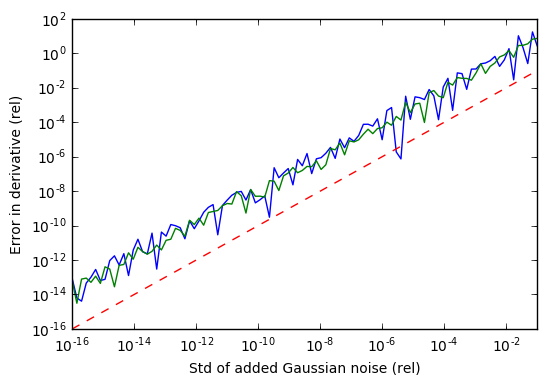

In [3]:
def f_(x):
    global scale
    return f(x)*(1 + np.random.normal(scale=scale))

err = [0]
errs = []
errs_est = []

np.random.seed(1)
scales = 10**(np.linspace(-16, -1, 100))
for scale in scales:
    errs.append(abs(differentiate(f_, x=1, h0=0.1, err=err)/df(x) - 1))
    errs_est.append(err[0])

plt.loglog(scales, errs)
plt.loglog(scales, errs_est)
plt.loglog(scales, scales, '--')
plt.ylabel('Error in derivative (rel)')
plt.xlabel('Std of added Gaussian noise (rel)')

An interesting point is that the function needs to be computed to about two orders of magnitude more accuracy than the desired accuracy of the derivative (see [Roy:2005] and [Eca:2009]).

[Roy:2005]: http://dx.doi.org/10.1016/j.jcp.2004.10.036 (Christopher J. Roy, "Review of code and solution verification procedures for computational simulation", J. Comp. Phys. 205(1), 131 - 156 (2005) )

[Eca:2009]: http://dx.doi.org/10.1016/j.compfluid.2009.01.003 (L. Eça and M. Hoekstra, "Evaluation of numerical error estimation based on grid refinement studies with the method of the manufactured solutions", Computers \& Fluids 38(8), 1580--1591 (2009) )
